In [8]:
import sys
sys.path.append("../")

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from tqdm.auto import trange, tqdm

In [6]:
#@title Imports
import os
import sys
import json
import copy
import random
import numpy as np
from tqdm import tqdm

import torch
torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as nnf
softplus = torch.nn.Softplus()
import torch.optim as torchopt
from pyro.nn import PyroSample

import pyro
from pyro import poutine
import pyro.distributions as dist
from pyro.optim import Adam
import pyro.optim as pyroopt
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.distributions import Normal, Categorical, OneHotCategorical
import matplotlib.pyplot as plt
import torch.distributions.constraints as constraints
from pyro.nn.module import to_pyro_module_

In [6]:
from util.StockDataset import normalize, StockDataset
from probabilistic import BNN

In [7]:
# set style of graphs
plt.style.use('ggplot')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [257]:
df = pd.read_csv('../../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")
X_train, X_test = train_test_split(df, test_size=0.1, shuffle=False)

In [29]:
class DeterministicNetwork(nn.Module):
  
    def __init__(self, 
              input_size=4, 
              hidden_size=32, 
              output_dim=1,
              dropout=0.2
              ):

        # initialize nn.Module
        super(DeterministicNetwork, self).__init__()
    
        # architecture
        self.model = nn.Sequential(
                    nn.Linear(input_size, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size, 16),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(16, output_dim)
                    )
    
        self.name = "deterministic_network"

    def forward(self, inputs, *args, **kwargs):
        """ Compute predictions on `inputs`. """
        return self.model(inputs)

In [259]:
class BayesianNetwork(PyroModule):

    def __init__(self, 
                input_size=4, 
                hidden_size=32, 
                output_size=1
                ):
        # initialize PyroModule
        super(BayesianNetwork, self).__init__()

        # BayesianNetwork extends PyroModule class
        self.det_network = DeterministicNetwork(input_size=4, hidden_size=32, output_dim=1)

        self.name = "bayesian_network"
      
    def model(self, x_data, y_data):
        """ Sets prior distributions and conditions on the observations. """
        # priors = {}
        # set Gaussian priors on the weights of self.det_network
        # for key, value in self.det_network.state_dict().items():
        #    loc = torch.zeros_like(value)
        #    scale = torch.ones_like(value)
        #    prior = Normal(loc=loc, scale=scale)    
        #    priors.update({str(key):prior})

        # pyro.random_module places `priors` over the parameters of the nn.Module 
        # self.det_network and returns a distribution, which upon calling 
        # samples a new nn.Module (`lifted_module`)
        # lifted_module = pyro.random_module("module", self.det_network, priors)()
        # lifted_module = PyroModule(self.det_network, priors)()
        to_pyro_module_(self.det_network)

        # Now we can attempt to be fully Bayesian:
        for m in self.det_network.modules():
            for name, value in list(m.named_parameters(recurse=False)):
                setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                                    .expand(value.shape)
                                                    .to_event(value.dim())))

        # samples are conditionally independent w.r.t. the observed data
        with pyro.plate("data", len(x_data)):
            out = self.det_network(x_data) # out.shape = (batch_size, num_classes)
            print(out)
            obs = pyro.sample("obs", Normal(out,y_data.std()), obs=y_data) # obs.shape = (batch_size)

    def guide(self, x_data, y_data=None):
        """ Samples from the Variational distribution and returns predictions. """

        # take random samples of det_network's weights from the chosen variational family
        # dists = {}
        # for key, value in self.det_network.state_dict().items():

            # torch.randn_like(x) builds a random tensor whose shape equals x.shape
        #    loc = pyro.param(str(f"{key}_loc"), torch.randn_like(value))
                                        # constraint=constraints.positive) 
        #    scale = pyro.param(str(f"{key}_scale"), torch.randn_like(value))
                                        # constraint=constraints.positive)

            # softplus is a smooth approximation to the ReLU function
            # which constraints the scale tensor to positive values
        #    distr = Normal(loc=loc, scale=softplus(scale))
            # distr = Normal(loc=x_data.mean(), scale=x_data.std())

            # add key-value pair to the samples dictionary
        #    dists.update({str(key):distr})

        # print(dists)

        # define a random module from the dictionary of distributions
        # lifted_module = pyro.random_module("module", self.det_network, dists)()
        # lifted_module = PyroModule(self.det_network, dists)()
        to_pyro_module_(self.det_network)

        # Now we can attempt to be fully Bayesian:
        for m in self.det_network.modules():
            for name, value in list(m.named_parameters(recurse=False)):
                setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                                    .expand(value.shape)
                                                    .to_event(value.dim())))

        with pyro.plate("data", len(x_data)):

            # compute predictions on `x_data`
            out = self.det_network(x_data)
            preds = nnf.relu(out)
            return preds
        
    def forward(self, inputs, n_samples=10, sample_idx=None, avg_prediction=True):
        """ Compute predictions on `inputs`. 
        `n_samples` is the number of samples from the posterior distribution.
        If `sample_idx` is provided, it is used as a seed for sampling a single
        model from the Variational family.
        If `avg_prediction` is True, it returns the average prediction on 
        `inputs`, otherwise it returns all predictions 
        """
        if sample_idx:
            # set random seeds for both torch and pyro
            random.seed(sample_idx)
            pyro.set_rng_seed(sample_idx)    

            # sample from the guide() function and evaluate it on `inputs`        
            guide_trace = poutine.trace(self.guide).get_trace(inputs)  

            # get the output prediction from the guide() function
            preds = [guide_trace.nodes['_RETURN']['value']]
        
        else:
            preds = []
            # take multiple samples
            for _ in range(n_samples):         
                guide_trace = poutine.trace(self.guide).get_trace(inputs)  
                preds.append(guide_trace.nodes['_RETURN']['value'])
        
        # list of tensors to tensor
        # preds.shape = (n_samples, batch_size, n_classes)
        preds = torch.stack(preds)

        # return predictions 
        return preds.mean(0) if avg_prediction else preds

    def __initTrainDl(self, x_train, batch_size, num_workers):
        train_dl = StockDataset(x_train)

        train_dl = DataLoader(train_dl, 
                              batch_size=batch_size, 
                              num_workers=num_workers,
                              # pin_memory=self.use_cuda,
                              shuffle=True
                              )

        return train_dl

    def __initValDl(self, x_test, batch_size, num_workers):
        val_dl = StockDataset(x_test)

        val_dl = DataLoader(val_dl, 
                            batch_size=self.batch_size, 
                            num_workers=num_workers,
                            # pin_memory=self.use_cuda,
                            shuffle=False
                            )
        
        return val_dl

    def fit(self, x_train, lr, batch_size, epochs, device):
        """ Learn network's weights using SVI. """
        # random.seed(0)
        # pyro.set_rng_seed(0)
        pyro.clear_param_store()

        scaler = normalize(x_train)
        x_train = scaler.fit_transform()
        train_loader = self.__initTrainDl(x_train, 
                                        batch_size=batch_size,
                                        num_workers=4,
                                        )
 
        # send bayesian network and deterministic network to device
        self.to(device)
        self.det_network.to(device)

        # ELBO loss minimization
        optimizer = pyro.optim.Adam({"lr":lr})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optimizer, loss=elbo)

        for epoch in range(epochs):
            loss = 0.0

            for x_batch, y_batch in train_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device) # .argmax(-1)

                loss += svi.step(x_data=x_batch, y_data=y_batch)

            total_loss = loss / len(train_loader.dataset)
            print(f"Epoch {epoch + 1}]\t loss: {total_loss:.2f}")

    def evaluate(self, x_test, device, batch_size, n_samples=10, avg_prediction=True):
        """ Evaluate network on test set. """
        # random.seed(0)
        # pyro.set_rng_seed(0)  

        scaler = normalize(x_test)
        x_test = scaler.fit_transform()
        test_loader = self.__initTrainDl(x_test, 
                                        batch_size=batch_size,
                                        num_workers=4,
                                        )
        
        self.to(device)
        self.det_network.to(device)

        output = torch.tensor([])
        # disable gradients computation
        with torch.no_grad():

            correct_predictions = 0.0

            # compute predictions on mini-batch
            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)# .argmax(-1)

                outputs = self.forward(x_batch, n_samples=n_samples, avg_prediction=avg_prediction)
                predictions = outputs.to(device)# .argmax(-1)
                output = torch.cat((output, predictions), 0)
        
        return output * scaler.std() + scaler.mean()

In [260]:
predictor = BayesianNetwork()
predictor.fit(X_train, batch_size=8, lr=0.01, epochs=5, device='cpu')

NotImplementedError: Module [PyroDeterministicNetwork] is missing the required "forward" function
Trace Shapes:    
 Param Sites:    
Sample Sites:    
    data dist   |
        value 8 |

In [ ]:
y_pred = predictor.evaluate(X_test, batch_size=8, n_samples=10, device='cpu')

/home/silvio/anaconda3/lib/python3.9/site-packages/pyro/primitives.py:404: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "


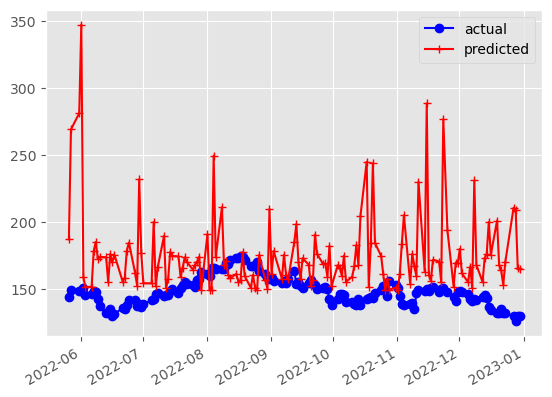

In [ ]:
y_test = (X_test['Close']).values 
days = np.array(X_test.index, dtype="datetime64[ms]")
            
fig = plt.figure()
            
axes = fig.add_subplot(111)
axes.plot(days, y_test, 'bo-', label="actual") 
axes.plot(days, y_pred, 'r+-', label="predicted")
            
fig.autofmt_xdate()
            
plt.legend()
plt.show()

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [217]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from tqdm.auto import trange, tqdm

In [56]:
class Net(PyroModule):
    def __init__(self,
                input_size=3,
                hidden_size=32,
                output_dim=1,
                ):
        super().__init__()
        self.name = "deterministic_network"

        self.fc1 = PyroModule[nn.Linear](input_size, hidden_size)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([hidden_size]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](hidden_size, 16)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([16, hidden_size]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([16]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](16, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, 16]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()        

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        # x = self.model(x)
        # mu = x.squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [341]:
class Net(PyroModule):
    def __init__(self,
                input_size=3,
                hidden_size=32,
                output_dim=1,
                ):
        super().__init__()
        self.name = "deterministic_network"

        self.model = PyroModule[nn.Sequential](
                PyroModule[nn.Linear](3, 32),
                PyroModule[nn.ReLU](),
                PyroModule[nn.Dropout](0.2),
                PyroModule[nn.Linear](32, 16),
                PyroModule[nn.ReLU](),
                PyroModule[nn.Dropout](0.2),
                PyroModule[nn.Linear](16, 1),
            )       

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        # x = self.relu(self.fc1(x))
        x = self.model(x)
        # mu = self.fc3(x).squeeze()
        # x = self.model(x)
        mu = x.squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [342]:
# set style of graphs
plt.style.use('ggplot')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [343]:
df = pd.read_csv('../../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")
x = df[['Open', 'High', 'Low']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

model = Net(input_size=3, hidden_size=32)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(len(y_test))
x_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()

for epoch in bar:
    loss = svi.step(x_train, y_train)
    bar.set_postfix(loss=f'{loss / x.shape[0]:.3f}')

  0%|          | 0/151 [00:00<?, ?it/s]

In [344]:
x_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.from_numpy(y_test.to_numpy()).float()

In [356]:
predictive = Predictive(model, guide=guide, num_samples=len(y_test),
                            return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_test)
# y_pred = preds['obs'].T.detach().numpy().mean(axis=1)

In [508]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [509]:
pred_summary = summary(samples)

In [510]:
pred_summary

{'obs': {'mean': tensor([135.4103, 140.3108, 138.9416, 144.9099, 139.2168, 144.0654, 141.2550,
          142.1139, 146.5389, 145.5992, 131.7729, 128.0849, 129.8584, 131.2114,
          125.6796, 125.9072, 127.2050, 133.4961, 131.3273, 133.2282, 138.7673,
          136.7686, 134.0873, 131.6220, 131.5506, 133.6735, 132.7320, 139.0185,
          138.8654, 140.8734, 143.3478, 140.7307, 135.0741, 142.1478, 143.3034,
          140.5267, 143.6293, 147.0892, 149.7845, 137.1974, 146.9640, 150.9314,
          154.4433, 155.7906, 157.0400, 152.1971, 157.9685, 155.5812, 157.5877,
          157.6009, 154.8250, 158.9759, 165.7863, 159.6490, 169.6672, 163.2502,
          165.2552, 164.9231, 165.1029, 165.2191, 162.9274, 159.7367, 160.0364,
          159.5399, 158.0329, 154.4061, 149.8519, 155.3789, 149.8219, 149.0632,
          145.2491, 141.3399, 150.0916, 157.1521, 150.5698, 147.2630, 151.1072,
          145.9493, 142.2335, 144.4649, 149.5834, 146.6567, 143.9260, 146.4052,
          148.0379, 140.4

In [378]:
y_pred = pred_summary['_RETURN']['mean'].detach().numpy()

In [379]:
y_pred

array([135.37823 , 140.26091 , 138.86357 , 144.92151 , 139.07434 ,
       144.06421 , 141.28601 , 142.10153 , 146.5485  , 145.55894 ,
       131.78172 , 128.09752 , 129.8195  , 131.21179 , 125.67712 ,
       125.88497 , 127.26684 , 133.47398 , 131.43646 , 133.21082 ,
       138.68933 , 136.7729  , 134.11784 , 131.60547 , 131.54997 ,
       133.734   , 132.71056 , 138.99153 , 138.88474 , 140.86287 ,
       143.34206 , 140.6749  , 135.12733 , 142.16823 , 143.32303 ,
       140.45499 , 143.62453 , 147.03998 , 149.78807 , 137.24709 ,
       147.02644 , 150.89317 , 154.37149 , 155.85779 , 157.0317  ,
       152.22542 , 157.97137 , 155.5525  , 157.5584  , 157.58191 ,
       154.83846 , 158.93547 , 165.88188 , 159.67534 , 169.62495 ,
       163.22107 , 165.27675 , 164.98499 , 165.12305 , 165.24059 ,
       162.87662 , 159.7666  , 159.96204 , 159.61461 , 158.08293 ,
       154.46066 , 149.92401 , 155.34508 , 149.7976  , 149.02177 ,
       145.19148 , 141.34291 , 150.09615 , 157.08096 , 150.559

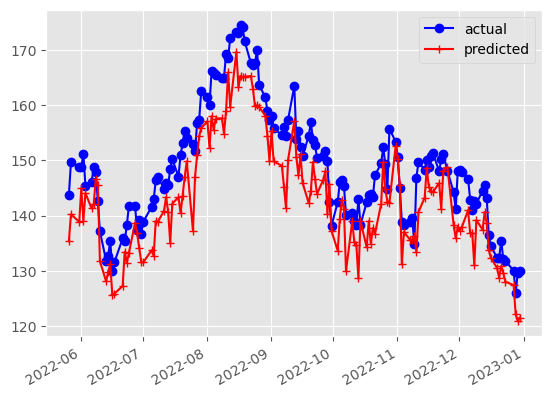

In [380]:
# y_test = (X_test['Close']).values 
days = np.array(X_test.index, dtype="datetime64[ms]")
            
fig = plt.figure()
            
axes = fig.add_subplot(111)
axes.plot(days, y_test, 'bo-', label="actual") 
axes.plot(days, y_pred, 'r+-', label="predicted")
            
fig.autofmt_xdate()
            
plt.legend()
plt.show()

In [523]:
import sys
sys.path.append("../../")

In [524]:
import pyro
from torch import nn
from pyro import poutine
import pyro.distributions as dist
from pyro.optim import Adam
import pyro.optim as pyroopt
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
from pyro.distributions import Normal, Categorical, OneHotCategorical
import matplotlib.pyplot as plt
import torch.distributions.constraints as constraints
from pyro.nn.module import to_pyro_module_
from tqdm.auto import trange, tqdm
from pyro.nn.module import to_pyro_module_
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.StockDataset import normalize, StockDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as torchopt
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import tqdm, trange

In [589]:
class Net(PyroModule):
    def __init__(self,
                input_size=4,
                hidden_size=32,
                output_dim=1,
                ):
        super().__init__()
        self.name = "deterministic_network"

        self.model = PyroModule[nn.Sequential](
                PyroModule[nn.Linear](input_size, hidden_size),
                PyroModule[nn.ReLU](),
                PyroModule[nn.Dropout](0.2),
                PyroModule[nn.Linear](hidden_size, 16),
                PyroModule[nn.ReLU](),
                PyroModule[nn.Dropout](0.2),
                PyroModule[nn.Linear](16, output_dim),
            )       

    def forward(self, x_data, y_data=None):
        x = self.model(x_data)
        mu = x.squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x_data.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y_data)
        return mu

class BNN(PyroModule):

    def __init__(self, 
                input_size=4, 
                hidden_size=32, 
                output_size=1
                ):
        # initialize PyroModule
        super(BNN, self).__init__()

        # BayesianNetwork extends PyroModule class
        self.model = Net(input_size=4, hidden_size=32, output_dim=1)
        self.optimizer = self.__initOptimizer()
        self.guide = AutoDiagonalNormal(self.model)

        self.name = "bayesian_network"

    def __initTrainDl(self, x_train, batch_size, num_workers):
        train_dl = StockDataset(x_train)

        train_dl = DataLoader(train_dl, 
                              batch_size=batch_size, 
                              num_workers=num_workers,
                              # pin_memory=self.use_cuda,
                              shuffle=False
                              )

        return train_dl

    def __initValDl(self, x_test, batch_size, num_workers):
        val_dl = StockDataset(x_test)

        val_dl = DataLoader(val_dl, 
                            batch_size=batch_size, 
                            num_workers=num_workers,
                            # pin_memory=self.use_cuda,
                            shuffle=False
                            )
        
        return val_dl
    
    def __initOptimizer(self):
        return pyro.optim.Adam({"lr": 0.01})

    def fit(self, 
            x_train,
            epochs=10,
            batch_size=8, 
            num_workers=4 
            ):
        """ Learn network's weights using SVI. """

        scaler = normalize(x_train)
        x_train = scaler.fit_transform()
        train_loader = self.__initTrainDl(x_train, 
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        )
 
        # send bayesian network and deterministic network to device
        # ELBO loss minimization
        svi = SVI(self.model, self.guide, self.optimizer, loss=Trace_ELBO())

        pyro.clear_param_store()
        for epoch_ndx in tqdm((range(1, epochs + 1)),position=0, leave=True):
            loss = 0.0

            for x_batch, y_batch in train_loader:
                
                loss = svi.step(x_data=x_batch, y_data=y_batch)

    def predict(self, 
                x_test, 
                batch_size
                ):
        """ Evaluate network on test set. """
        # random.seed(0)
        # pyro.set_rng_seed(0)  

        scaler = normalize(x_test)
        x_test = scaler.fit_transform()
        test_loader = self.__initValDl(x_test, 
                                        batch_size=batch_size,
                                        num_workers=4,
                                        )
        output = torch.tensor([])
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                predictive = Predictive(model=self.model, 
                                            guide=self.guide, 
                                            num_samples=batch_size,
                                            return_sites=("linear.weight", 
                                                        "obs", 
                                                        "_RETURN")
                                            )

                samples = predictive(x_batch)
                site_stats = {}
                for k, v in samples.items():
                    site_stats[k] = {
                        "mean": torch.mean(v, 0)
                    }

                y_pred = site_stats['_RETURN']['mean']
                output = torch.cat((output, y_pred), 0)
        
        return output.detach().numpy() * scaler.std() + scaler.mean()
        

In [590]:
df = pd.read_csv('../../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")
X_train, X_test = train_test_split(df, test_size=0.1, shuffle=False)

In [591]:
predictor = BNN()
predictor.fit(X_train, batch_size=8, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [592]:
y_pred = predictor.predict(X_test, batch_size=8)

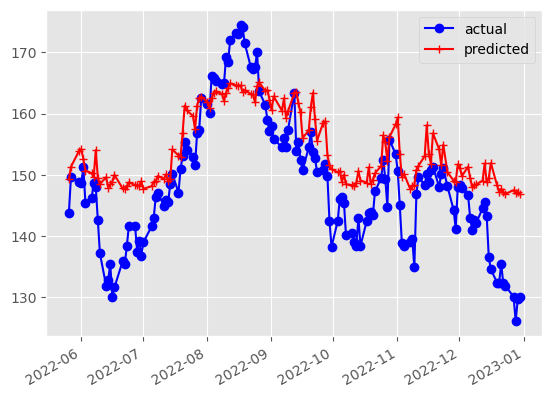

In [593]:
# y_test = (X_test['Close']).values 
days = np.array(X_test.index, dtype="datetime64[ms]")
            
fig = plt.figure()
            
axes = fig.add_subplot(111)
axes.plot(days, y_test, 'bo-', label="actual") 
axes.plot(days, y_pred, 'r+-', label="predicted")
            
fig.autofmt_xdate()
            
plt.legend()
plt.show()